In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.linear_model import SGDOneClassSVM
from sklearn.metrics import roc_auc_score
from tqdm import tqdm, trange

from dataset import Dataset, get_transac_n_seconds
from models import Classifier, Projector, VAE
from trainers.drocc_trainer import DROCCTrainer, adjust_learning_rate
from trainers.dsvdd_trainer import DeepSVDD
from trainers.vae_trainer import LossVAE

In [2]:
df = pd.read_csv('~/Bureau/Datasets/TimeSeries/creditcard.csv')
#df = pd.read_csv('creditcard.csv')
df.head()

DEVICE="cuda"
BATCH_SIZE=256

In [3]:
normal_rate = len(df[df['Class']==0])/ len(df)
anormal_rate = len(df[df['Class']==1])/ len(df)

print(f"normal rate: {normal_rate} ; anormal rate: {anormal_rate}")

normal rate: 0.9982725143693799 ; anormal rate: 0.001727485630620034


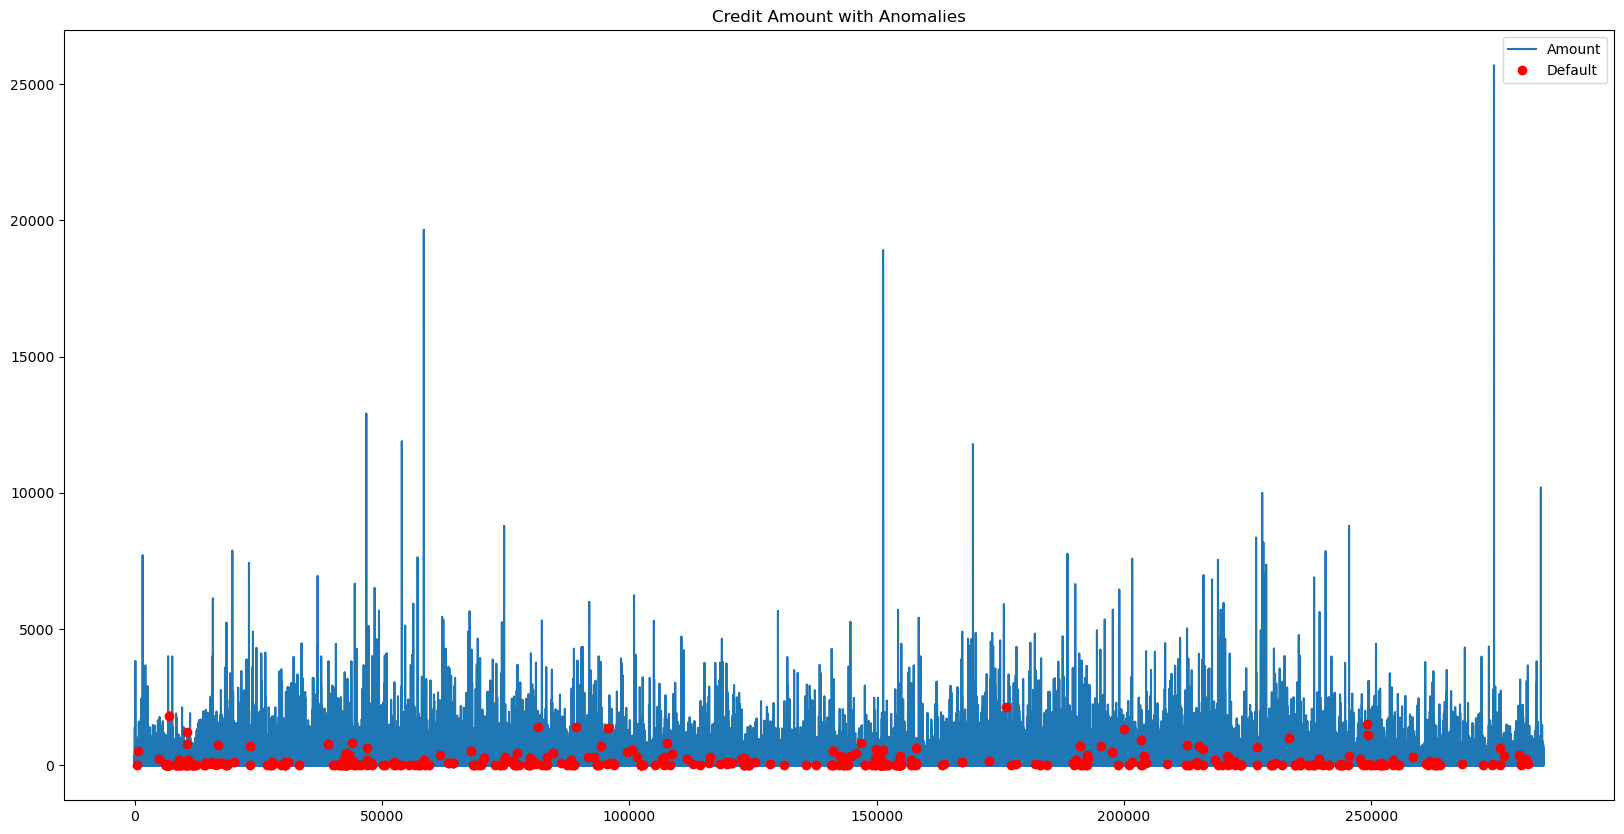

In [4]:
plt.figure(figsize=(20, 10))

value = df['Amount']
anomalies = df['Class']

indices = range(len(value))
anomalies_indices = [i for i in df[df['Class']==1].index]

plt.plot(indices, value, label='Amount')
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label='Default')
plt.title('Credit Amount with Anomalies')
plt.legend()

# Supervised Setting

In [5]:
dataset = get_transac_n_seconds(df, seconds=1) # Takes 10 sec approx

train_size = int(0.6*len(dataset))

train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]

scaler = StandardScaler()

train = train.copy()
test = test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

### Basic DNN Classifier

In [15]:
BATCH_SIZE=256
EPOCHS=2
LR=1e-3

In [16]:
trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = Classifier().to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)

In [17]:
for epoch in range(EPOCHS):
    epoch_loss = 0
    batch_pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{EPOCHS} Batches", leave=False)  # Inner progress bar for batches
    for inputs, targets in batch_pbar:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        # Forward pass
        preds = model(inputs)
        preds = torch.squeeze(preds, dim=1)
        targets = targets.float()
        loss = criterion(preds, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate loss
        epoch_loss += loss.item()

        # Optionally update the inner pbar with the current loss
        batch_pbar.set_postfix(loss=loss.item())

    # Optionally update the outer pbar with the epoch loss
    print(f"epoch loss : {loss.item()/len(trainloader)}")

epoch loss : 2.3397238517994297e-06


epoch loss : 9.226446663180065e-07


In [18]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = model(test_batch).squeeze()
        preds = torch.sigmoid(preds)
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:00<00:00, 575.34it/s]

ROC-AUC score: 0.9432161714339127


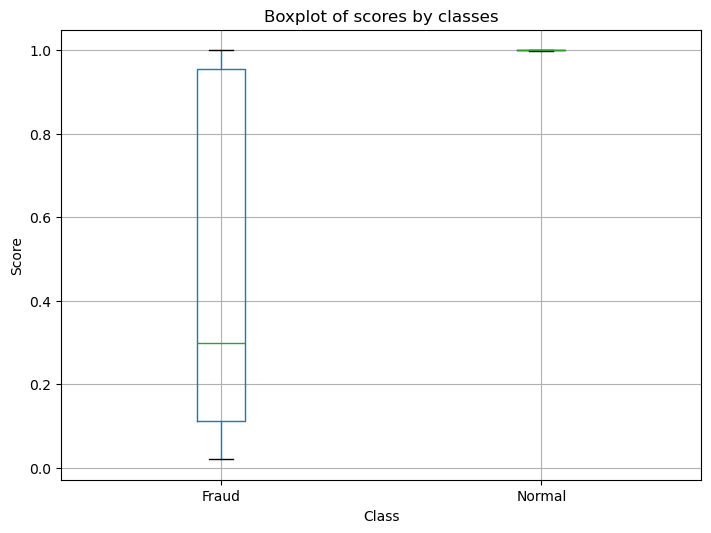

In [19]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

plt.title("Boxplot of scores by classes")
plt.suptitle("") 
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

plt.show()

# Unsupervised Setting

In [6]:
dataset = df.copy()

train_size = int(0.6 * len(dataset))
train = dataset.iloc[:train_size]
test = dataset.iloc[train_size:]
train = train[train['Class'] == 0]

new_train_size = len(train)

dataset = pd.concat([train, test], ignore_index=True)
dataset = get_transac_n_seconds(dataset, seconds=2)

train = dataset.iloc[:new_train_size]
test = dataset.iloc[new_train_size:]

scaler = StandardScaler()

train, test = train.copy(), test.copy()

train['Amount'] = scaler.fit_transform(train['Amount'].values.reshape(-1, 1))
test['Amount'] = scaler.transform(test['Amount'].values.reshape(-1, 1))

trainset = Dataset(train)
testset = Dataset(test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

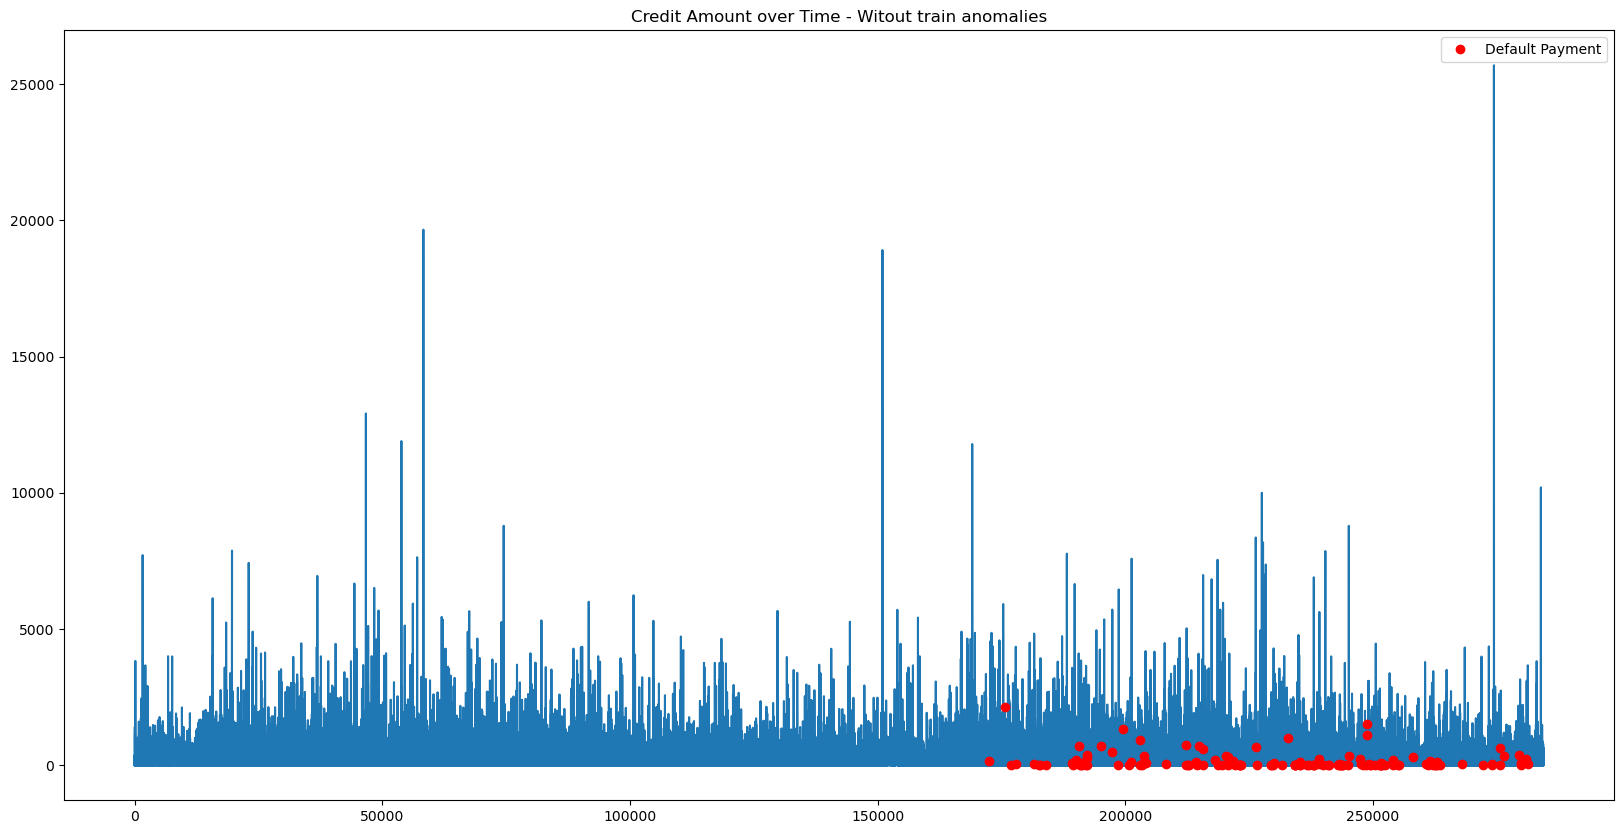

In [7]:
plt.figure(figsize=(20, 10))

value = dataset['Amount']
anomalies = dataset['Class']

indices = range(len(value))
anomalies_indices = [i for i in dataset[dataset['Class']==1].index]

plt.plot(indices, value)
plt.plot( anomalies_indices, value[anomalies_indices], "ro", label="Default Payment")
plt.title("Credit Amount over Time - Witout train anomalies")
plt.legend()

### SGD OC-SVM

In [22]:
X_train = train.drop(['Time', 'Class'], axis=1)
X_test = test.drop(['Time', 'Class'], axis=1)
y_test = test['Class']

In [23]:
clf = SGDOneClassSVM().fit(X_train)
prediction = clf.predict(X_test)

prediction = clf.predict(X_test)
prediction = np.where(prediction == -1, 1, 0)

score = roc_auc_score(y_test, prediction)
print(f"ROC-AUC score: {score}")

ROC-AUC score: 0.4890642813259716


### Deep SVDD

In [24]:
LR=1e-3
EPOCHS=10
BATCH_SIZE=256
WEIGHT_DECAY=1e-6
PROJ_DIM=32

In [25]:
model = Projector(proj_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[0], gamma=0.1)

In [26]:
svdd = DeepSVDD(model=model, proj_dim=PROJ_DIM, device=DEVICE)
center = svdd.initialize_center(trainloader=trainloader)
results = svdd.train(trainloader=trainloader, epochs=EPOCHS, optimizer=optimizer, scheduler=scheduler)

model = results["model"]
center = results["center"]

Training: 100%|██████████| 667/667 [00:01<00:00, 453.06it/s]


Epoch 1/10 ; Loss: 1.0719


Training: 100%|██████████| 667/667 [00:01<00:00, 505.13it/s]


Epoch 2/10 ; Loss: 0.3784


Training: 100%|██████████| 667/667 [00:01<00:00, 464.21it/s]


Epoch 3/10 ; Loss: 0.1916


Training: 100%|██████████| 667/667 [00:01<00:00, 518.63it/s]


Epoch 4/10 ; Loss: 0.1232


Training: 100%|██████████| 667/667 [00:01<00:00, 507.25it/s]


Epoch 5/10 ; Loss: 0.0866


Training: 100%|██████████| 667/667 [00:01<00:00, 482.18it/s]


Epoch 6/10 ; Loss: 0.0633


Training: 100%|██████████| 667/667 [00:01<00:00, 518.12it/s]


Epoch 7/10 ; Loss: 0.0472


Training: 100%|██████████| 667/667 [00:01<00:00, 513.15it/s]


Epoch 8/10 ; Loss: 0.0358


Training: 100%|██████████| 667/667 [00:01<00:00, 457.62it/s]


Epoch 9/10 ; Loss: 0.0277


Training: 100%|██████████| 667/667 [00:01<00:00, 503.03it/s]

Epoch 10/10 ; Loss: 0.0219


In [27]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        proj = model(test_batch)
        dist = torch.sum((proj - center) ** 2, dim=1)
        all_preds.append(-dist.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:00<00:00, 498.77it/s]

ROC-AUC score: 0.9498537057438905


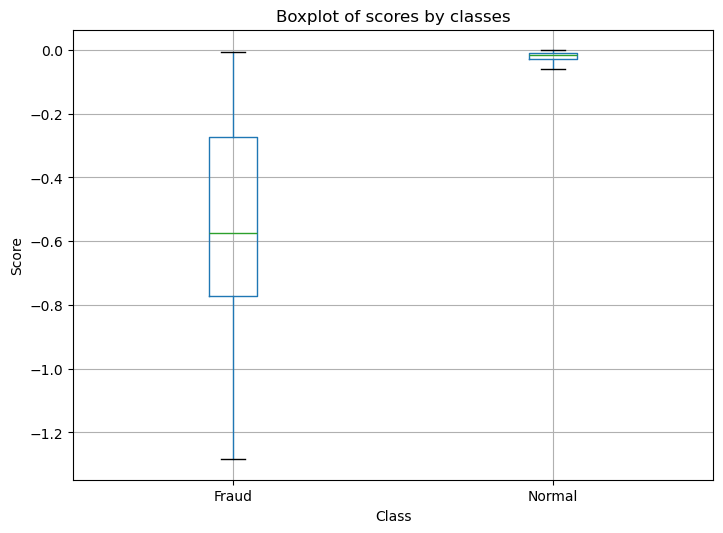

In [28]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### DROCC

In [29]:
LR=1e-3
EPOCHS=4
BATCH_SIZE=256

CE_EPOCHS=1
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=50

GAMMA=2
LAMBDA=1
RADIUS=5

In [30]:
model = Classifier().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

In [31]:
trainer = DROCCTrainer(model, optimizer, lamda=LAMBDA, radius=RADIUS, gamma=GAMMA, device=DEVICE)
trainer.train(trainloader, learning_rate=LR, lr_scheduler=adjust_learning_rate, total_epochs=EPOCHS,
             ascent_step_size=ASCENT_STEP_SIZE, ascent_num_steps=ASCENT_NUM_STEPS, only_ce_epochs = CE_EPOCHS)

model = trainer.get_model()

100%|██████████| 667/667 [00:01<00:00, 470.21it/s]


Epoch: 0, CE Loss: 0.03452526405453682, AdvLoss: 0.0


100%|██████████| 667/667 [00:13<00:00, 48.56it/s]


Epoch: 1, CE Loss: 0.728228747844696, AdvLoss: 0.9679818153381348


100%|██████████| 667/667 [00:14<00:00, 46.20it/s]


Epoch: 2, CE Loss: 0.6660177707672119, AdvLoss: 0.5858055353164673


100%|██████████| 667/667 [00:13<00:00, 48.25it/s]

Epoch: 3, CE Loss: 0.6423050165176392, AdvLoss: 0.5869502425193787


In [32]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        preds = torch.sigmoid(model(test_batch).squeeze())
        all_preds.append(preds.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:00<00:00, 602.29it/s]

ROC-AUC score: 0.9523880569987029


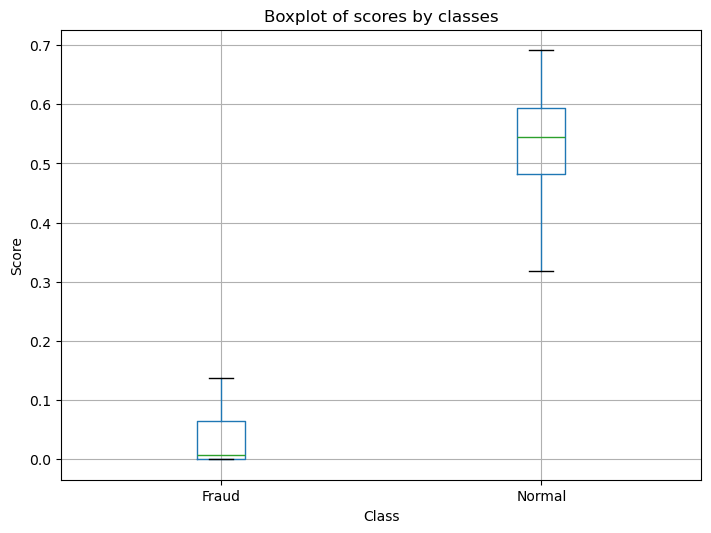

In [33]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### VAE - Reconstruction Loss

In [14]:
LR=1e-4
EPOCHS=10
BATCH_SIZE=256
LATENT_DIM=32

In [15]:
model = VAE(in_dim=30, hidden_dims=[128, 128], latent_dim=LATENT_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = LossVAE()

In [16]:
pbar = trange(EPOCHS, desc="Training")
for epoch in pbar:
    epoch_loss = 0

    for inputs, targets in trainloader:
        inputs = inputs.to(DEVICE)
        reconstructed, mu, logvar = model(inputs)
        loss = criterion(inputs, reconstructed, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss+=loss.item()

    epoch_loss = epoch_loss/len(trainloader)
    pbar.set_description(f"epoch : {epoch} ; loss : {epoch_loss}")

epoch : 9 ; loss : 13172.124720171652: 100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


In [19]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        reconstructed, mu, logvar = model(test_batch)
        loss = torch.sum((test_batch - reconstructed) ** 2, dim=1) -0.5 * torch.sum(1+logvar - mu**2 - logvar.exp(), dim=1)
        all_preds.append(-loss.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:00<00:00, 539.56it/s]

ROC-AUC score: 0.9219018093511683


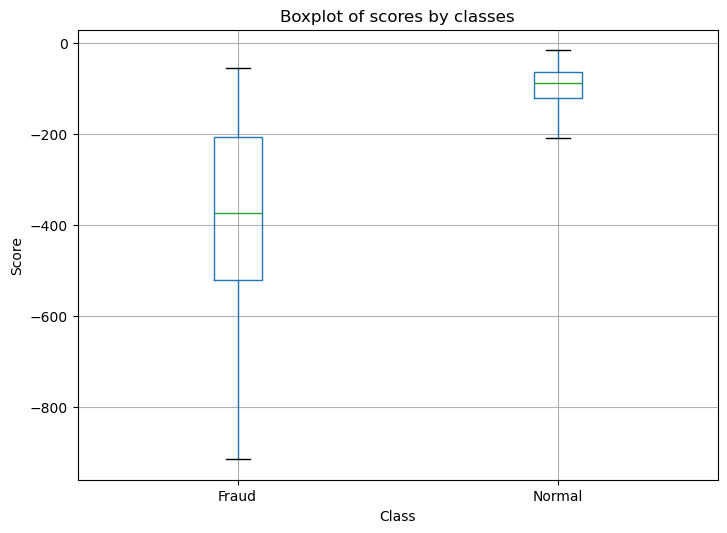

In [20]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()

### Gaussian Projector:

In [54]:
LR=1e-3
EPOCHS=5
BATCH_SIZE=256

CE_EPOCHS=0
ASCENT_STEP_SIZE=0.1
ASCENT_NUM_STEPS=20

GAMMA=2
LAMBDA=1
RADIUS=2

PROJ_DIM=32

In [55]:
class Projector(nn.Module):
    def __init__(self, in_dim=30, hidden_dim=128, latent_dim=32):
        super(Projector, self).__init__()

        self.seq = nn.Sequential(
            nn.Linear(in_features=in_dim, out_features=hidden_dim, bias=False),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(in_features=hidden_dim, out_features=latent_dim, bias=False)
        self.fc_logvar = nn.Linear(in_features=hidden_dim, out_features=latent_dim, bias=False)

    def forward(self, x):
        h = self.seq(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

In [56]:
model = Projector(latent_dim=PROJ_DIM).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR)

def kl_div(mu, logvar, true_mu):
    loss = torch.mean(-0.5 * torch.sum(1+logvar - mu**2 + true_mu**2 - logvar.exp(), dim=1), dim=0)
    return loss

In [57]:
eps=0.1

n_samples = 0
true_mu = torch.zeros(PROJ_DIM).to(DEVICE)

model.eval()
with torch.no_grad():
    for x, _ in tqdm(trainloader, desc="Initialisation de la moyenne"):
        x = x.to(DEVICE)
        mean, logvar = model(x)
        n_samples += mean.shape[0]
        true_mu += torch.sum(mean, dim=0)
true_mu /= n_samples

true_mu[(abs(true_mu) < eps) & (true_mu < 0)] = -eps
true_mu[(abs(true_mu) < eps) & (true_mu > 0)] = eps

model.train()

Initialisation de la moyenne: 100%|██████████| 667/667 [00:01<00:00, 536.31it/s]


Projector(
  (seq): Sequential(
    (0): Linear(in_features=30, out_features=128, bias=False)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=128, out_features=32, bias=False)
  (fc_logvar): Linear(in_features=128, out_features=32, bias=False)
)

In [58]:
def one_class_adv_loss(x_train_data):
    # Randomly sample points around the training data
    # We will perform SGD on these to find the adversarial points
    x_adv = torch.randn(x_train_data.shape).to(DEVICE).detach().requires_grad_()
    x_adv_sampled = x_adv + x_train_data

    for step in range(ASCENT_NUM_STEPS):
        with torch.enable_grad():
            
            mu, logvar = model(x_adv_sampled)         
            new_loss = kl_div(mu, logvar, true_mu=true_mu)
            grad = torch.autograd.grad(new_loss, [x_adv_sampled])[0]
            grad_norm = torch.norm(grad, p=2, dim = tuple(range(1, grad.dim())))
            grad_norm = grad_norm.view(-1, *[1]*(grad.dim()-1))
            grad_normalized = grad/grad_norm 
        with torch.no_grad():
            x_adv_sampled.add_(ASCENT_NUM_STEPS * grad_normalized)
        if (step + 1) % 10==0:
            # Project the normal points to the set N_i(r)
            h = x_adv_sampled - x_train_data
            norm_h = torch.sqrt(torch.sum(h**2, 
                                            dim=tuple(range(1, h.dim()))))
            alpha = torch.clamp(norm_h, RADIUS, 
                                GAMMA * RADIUS).to(DEVICE)
            # Make use of broadcast to project h
            proj = (alpha/norm_h).view(-1, *[1] * (h.dim()-1))
            h = proj * h
            x_adv_sampled = x_train_data + h  #These adv_points are now on the surface of hyper-sphere
    adv_mu, adv_logvar = model(x_adv_sampled)
    adv_loss = kl_div(adv_mu, adv_logvar, true_mu)
    assert not torch.isnan(adv_loss), "NAN"
    return adv_loss

In [59]:
for epoch in range(EPOCHS): 
    model.train()
    adjust_learning_rate(epoch, EPOCHS, CE_EPOCHS, LR, optimizer)
    

    epoch_adv_loss = torch.tensor([0]).type(torch.float32).to(DEVICE)  #AdvLoss
    epoch_ce_loss = 0  
    
    batch_idx = -1
    for data, target in tqdm(trainloader):
        batch_idx += 1
        data, target = data.to(DEVICE), target.to(DEVICE)
        # Data Processing
        data = data.to(torch.float)
        target = target.to(torch.float)
        target = torch.squeeze(target)
        optimizer.zero_grad()
        
        mean, logvar = model(data)
        ce_loss = kl_div(mean, logvar, true_mu).mean()

        epoch_ce_loss += ce_loss

        if  epoch >= CE_EPOCHS:
            data = data[target == 1]
            # AdvLoss 
            adv_loss = one_class_adv_loss(data)
            epoch_adv_loss += adv_loss
            loss = ce_loss + adv_loss * LAMBDA
        else: 
            # If only CE based training has to be done
            loss = ce_loss
        
        # Backprop
        loss.backward()
        optimizer.step()
            
    epoch_ce_loss = epoch_ce_loss/(batch_idx + 1)  #Average CE Loss
    epoch_adv_loss = epoch_adv_loss/(batch_idx + 1) #Average AdvLoss
    print('Epoch: {}, CE Loss: {}, AdvLoss: {}'.format(
        epoch, epoch_ce_loss.item(), epoch_adv_loss.item())) 

100%|██████████| 667/667 [00:09<00:00, 71.28it/s]


Epoch: 0, CE Loss: -1.055315375328064, AdvLoss: -0.8956722021102905


100%|██████████| 667/667 [00:09<00:00, 73.35it/s]


Epoch: 1, CE Loss: -1.135550618171692, AdvLoss: -1.1264568567276


100%|██████████| 667/667 [00:08<00:00, 74.64it/s]


Epoch: 2, CE Loss: -1.1372801065444946, AdvLoss: -1.1339720487594604


100%|██████████| 667/667 [00:09<00:00, 72.03it/s]


Epoch: 3, CE Loss: -1.1374742984771729, AdvLoss: -1.1347771883010864


100%|██████████| 667/667 [00:09<00:00, 70.34it/s]

Epoch: 4, CE Loss: -1.1375640630722046, AdvLoss: -1.1351985931396484


In [60]:
all_preds = []
all_tar = []

model.eval()
with torch.no_grad():
    for test_batch, targets in tqdm(testloader, leave=True):
        test_batch, targets = test_batch.to(DEVICE), targets.to(DEVICE)
        mu, logvar = model(test_batch)
        loss = -0.5 * torch.sum(1+logvar - mu**2 + true_mu**2 - logvar.exp(), dim=1)
        all_preds.append(-loss.cpu())
        all_tar.append(targets.cpu())

all_tar = torch.cat(all_tar)
all_preds = torch.cat(all_preds)

score = roc_auc_score(all_tar, all_preds)
print(f"ROC-AUC score: {score}")

100%|██████████| 446/446 [00:00<00:00, 613.95it/s]

ROC-AUC score: 0.9469926324257951


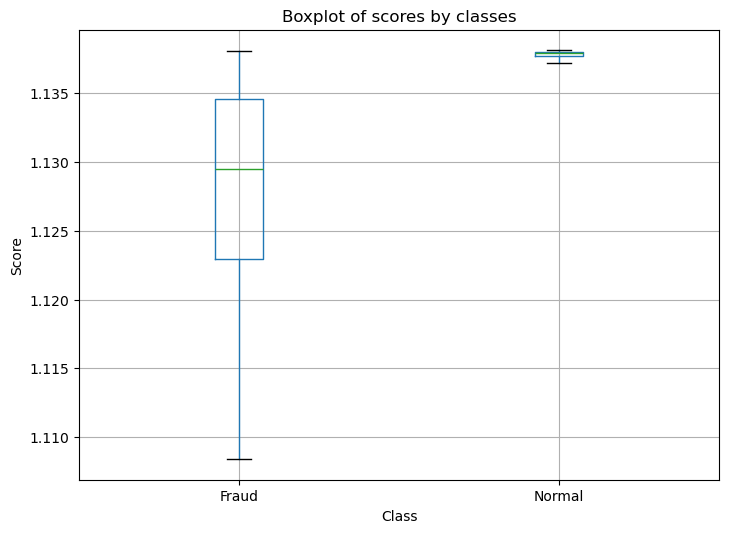

In [61]:
results = pd.DataFrame({})
results["pred"] = all_preds
results['class']=all_tar

results.boxplot(column='pred', by='class', figsize=(8, 6), showfliers=False)

# Ajouter des labels et un titre
plt.title("Boxplot of scores by classes")
plt.suptitle("")  # Supprime le titre automatique de pandas
plt.xlabel("Class")
plt.ylabel("Score")
plt.xticks(ticks=[1, 2], labels=['Fraud', 'Normal'])

# Afficher le graphique
plt.show()